Define a toy data generative process that creates pairs of image and caption data.

Concept space :
- Background : Solid (black, white), Gradient (blue/purple to black / white, red/orange to black / brown), Pattern (stripes, dots, waves : blue/purple/green/brown over black / white)
- Shape : Circle, Square, Triangle, Rectangle
- Color : Red, Green, Blue, Yellow
- Size : Small, Medium, Large
- Position : Top, center, bottom | left, center, right

Up to 3 shapes can be present in an image.

In [20]:
import os, requests, zipfile, random, math
import copy

import torch
import numpy as np
# from nnsight.models.UnifiedTransformer import UnifiedTransformer
# import clip
from transformers import CLIPModel, CLIPProcessor, SiglipModel, SiglipProcessor
import nnsight

import overcomplete
from overcomplete.metrics import r2_score
# import losses
# import train

import datasets
import pandas as pd
from pycocotools.coco import COCO

from tqdm import tqdm

from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

# import metrics
from src.utils import fit_and_plot_pca, plot_pca

device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [6]:
# from PIL import ImageColor, Image, ImageDraw

# c = ImageColor.colormap
# n = len( c )

# cols        = 4
# rows        = ((n-1) // cols) +1
# cellHeight  = 30
# cellWidth   = 170
# imgHeight   = cellHeight * rows
# imgWidth    = cellWidth * cols

# i = Image.new( "RGB", (imgWidth,imgHeight), (0,0,0) )
# a = ImageDraw.Draw( i )

# for idx, name in enumerate( c ):
#     y0 = cellHeight * (idx // cols)
#     y1 = y0 + cellHeight
#     x0 = cellWidth * (idx % cols)
#     x1 = x0 + (cellWidth / 4)

#     a.rectangle( [ x0, y0, x1, y1 ], fill=name, outline='black' )
#     a.text( ( x1+1, y0+10 ), name, fill='white' )

# i.save( 'color_chart.png' )

In [8]:
class ToyNonIsoE:
    def __init__(self, d_model, nb_concepts, L0, nb_samples=10000, cosim=0.4):
        """
        - Creates nb_concepts // 2 unique concepts, D_I
        - duplicates them by rotating them with a rotation matrix such that the cosim between any original concept and its duplicates is 0.4 D_T

        Generates codes Z_I and Z_T from the same underlying concepts but with their respective realisations D_I and D_T.
        """
        assert nb_concepts % 2 == 0, "Number of concepts must be even"
        self.d_model = d_model
        self.nb_concepts = nb_concepts
        self.nb_samples = nb_samples
        self.L0 = L0
        self.cosim = cosim

        # Generate concepts
        self.concepts = self._generate_concepts()
        self.frequencies = self._generate_frequencies()

        # Generate codes : select L0 concepts at random
        self.Z_I, self.Z_T = self._generate_codes()
        self.I, self.T = self.Z_I @ self.concepts, self.Z_T @ self.concepts
        I_norms = np.linalg.norm(self.I, axis=1, keepdims=True)
        T_norms = np.linalg.norm(self.T, axis=1, keepdims=True)
        self.I = self.I / I_norms
        self.T = self.T / T_norms
        self.Z_I = self.Z_I / I_norms
        self.Z_T = self.Z_T / T_norms
        
    def _generate_concepts(self):
        n = self.nb_concepts // 2
        base_concepts = np.random.randn(n, self.d_model)
        base_concepts = base_concepts / np.linalg.norm(base_concepts, axis=1, keepdims=True)

        # Generate rotated vectors with cosine similarity ~cosim
        angle = np.arccos(self.cosim)
        rotated_concepts = []

        for v in base_concepts:
            # Create a random vector orthogonal to v
            r = np.random.randn(self.d_model)
            r -= r.dot(v) * v
            r /= np.linalg.norm(r)

            # Rotate v towards r to get target cosine similarity
            v_rot = np.cos(angle) * v + np.sin(angle) * r
            rotated_concepts.append(v_rot)

        concepts = np.vstack([base_concepts, rotated_concepts])
        return concepts
    
    def _generate_frequencies(self):
        n = self.nb_concepts // 2
        freqs = np.logspace(np.log10(0.5), np.log10(1e-3), num=n)
        freqs = np.tile(freqs, 2)
        return freqs
    
    def _generate_codes(self):
        n = self.nb_concepts // 2
        N = self.nb_samples
        f = self.frequencies[:n]
        
        Z_I = np.zeros((N, n*2))
        Z_T = np.zeros((N, n*2))

        for i in range(N):
            idxs = np.random.choice(n, size=self.L0, replace=False, p=f/np.sum(f))
            Z_I[i, idxs] = 1
            Z_T[i, idxs + n] = 1
        
        return Z_I, Z_T

class ToyIsoE:
    def __init__(self, d_model, nb_concepts, L0, nb_samples=10000, cosim=0.4):
        """
        let n = nb_concepts * 0.1
        - Create n concepts in the first d_model * 0.1 dimensions D_I
        - Create n concepts in the next d_model * 0.1 dimensions D_T
        - Create nb_concepts - 2 * n concepts in the remaining dimensions D_B. Dupplicate these with a small modality specific noise.

        Generates codes Z_I and Z_T with L0 - 1 concepts from D_B, and 1 concept from D_I and D_T respectively with an activation such that the cosine similarity between I and T is ~cosim.
        """
        self.d_model = d_model
        self.nb_concepts = nb_concepts
        self.L0 = L0
        self.nb_samples = nb_samples
        self.cosim = cosim

        self.D_I, self.D_T, self.D_B_I, self.D_B_T = self._generate_concepts()
        self.concepts = np.vstack([self.D_I, self.D_T, self.D_B_I, self.D_B_T])
        self.frequencies = self._generate_frequencies()

        self.Z_I, self.Z_T = self._generate_codes()
        self.I, self.T = self.Z_I @ self.concepts, self.Z_T @ self.concepts

        I_norms = np.linalg.norm(self.I, axis=1, keepdims=True)
        T_norms = np.linalg.norm(self.T, axis=1, keepdims=True)
        self.I = self.I / I_norms
        self.T = self.T / T_norms
        self.Z_I = self.Z_I / I_norms
        self.Z_T = self.Z_T / T_norms
        
    def _generate_concepts(self):
        n = int(self.nb_concepts * 0.1)
        b = int((self.nb_concepts - 2 * n) / 2) 
        d_I_dim = int(self.d_model * 0.1)
        d_T_dim = int(self.d_model * 0.1)
        d_B_dim = self.d_model - d_I_dim - d_T_dim

        D_I = np.zeros((n, self.d_model))
        D_I_offset = np.random.randn(1, d_I_dim) # shape (1, d_I_dim)
        D_I_offset /= np.linalg.norm(D_I_offset)  # Normalize the offset
        D_I[:, :d_I_dim] = np.random.randn(n, d_I_dim) + D_I_offset * 10
        D_I /= np.linalg.norm(D_I, axis=1, keepdims=True)

        D_T = np.zeros((n, self.d_model))
        D_T_offset = np.random.randn(1, d_T_dim)  # shape (1, d_T_dim)
        D_T_offset /= np.linalg.norm(D_T_offset)  # Normalize the offset
        D_T[:, d_I_dim:d_I_dim + d_T_dim] = np.random.randn(n, d_T_dim) + D_T_offset * 10
        D_T /= np.linalg.norm(D_T, axis=1, keepdims=True)

        D_B = np.zeros((b, self.d_model))
        D_B[:, d_I_dim + d_T_dim:] = np.random.randn(b, d_B_dim)
        D_B /= np.linalg.norm(D_B, axis=1, keepdims=True)

        noisy_cosim = 0.60

        D_B_I_noise = np.zeros((b, self.d_model))
        D_B_I_noise[:, :d_I_dim] = np.random.randn(b, d_I_dim) + D_I_offset * 0
        D_B_I_noise /= np.linalg.norm(D_B_I_noise, axis=1, keepdims=True)
        D_B_I = np.sqrt(noisy_cosim / (1 - noisy_cosim)) * D_B + D_B_I_noise
        D_B_I /= np.linalg.norm(D_B_I, axis=1, keepdims=True)

        D_B_T_noise = np.zeros((b, self.d_model))
        D_B_T_noise[:, d_I_dim:d_I_dim + d_T_dim] = np.random.randn(b, d_T_dim) + D_T_offset * 0
        D_B_T_noise /= np.linalg.norm(D_B_T_noise, axis=1, keepdims=True)
        D_B_T = np.sqrt(noisy_cosim / (1 - noisy_cosim)) * D_B + D_B_T_noise
        D_B_T /= np.linalg.norm(D_B_T, axis=1, keepdims=True)

        return D_I, D_T, D_B_I, D_B_T
        
    def _generate_frequencies(self):
        n = self.D_I.shape[0]
        b = self.D_B_T.shape[0]

        freqs_I = np.ones(n)
        freqs_T = np.ones(n)
        freqs_B_I = np.logspace(np.log10(0.5), np.log10(1e-3), num=b)
        freqs_B_T = np.logspace(np.log10(0.5), np.log10(1e-3), num=b)

        freqs = np.concatenate([freqs_I, freqs_T, freqs_B_I, freqs_B_T])
        return freqs
    
    def _generate_codes(self):
        n = self.D_I.shape[0]
        b = self.D_B_I.shape[0]
        offset_I = 0
        offset_T = n
        offset_B_I = 2 * n
        offset_B_T = 2 * n + b
        f_B = self.frequencies[2*n:2*n + b]

        Z_I = np.zeros((self.nb_samples, self.nb_concepts))
        Z_T = np.zeros((self.nb_samples, self.nb_concepts))

        for i in range(self.nb_samples):
            # Choose shared base concepts
            idxs_B = np.random.choice(b, size=self.L0 - 1, replace=False, p=f_B/np.sum(f_B))
            idx_I = np.random.randint(n)
            idx_T = np.random.randint(n)

            # Set I and T components with scaling to achieve target cosine
            a = np.linalg.norm(self.D_B_I[idxs_B].sum(axis=0))
            beta = self.cosim
            alpha = (1 / a) * np.sqrt(beta / (1 - beta))

            Z_I[i, offset_B_I + idxs_B] = alpha + np.random.randn(len(idxs_B)) * 0.05
            Z_T[i, offset_B_T + idxs_B] = alpha + np.random.randn(len(idxs_B)) * 0.05
            Z_I[i, offset_I + idx_I] = 1
            Z_T[i, offset_T + idx_T] = 1

        return Z_I, Z_T

class ToyGeneral:
    def __init__(self, d_model, nb_concepts, L0, nb_samples=10000, target_aligned_cosim=0.4, unimodal_cosim=0.9):
        """
        let n = nb_concepts * 0.1, d = d_model * 0.1
        - Create n concepts in the first d dimensions D_I
        - Create n concepts in the next d dimensions D_T
        - Create n * 4 concepts in the remaining d * 8 dimensions D_B. These serve as common bimodal information.
        - Create n * 4 concepts in the first d dimensions D_B_I. These serve as modality specific information on top of D_B.
        - Create n * 4 concepts in the next d dimensions D_B_T. These serve as modality specific information on top of D_B.

        - Store two "ground truth" dictionaries :
            - D = D_I + D_T + D_B + D_B_I + D_B_T
            - D' = D_I + D_T + (D_B + D_B_I) + (D_B + D_B_T)

        "unimodal_cosim" = t1 controls the cosine similarity between (D_B + D_B_I) and (D_B + D_B_T), the two instanciation of the abstract D_B.
            - In practice, with all dictionary atoms in the unite sphere, this means that (D_B + D_B_I) = sqrt(t1) D_B + sqrt(1 - t1) D_B_I
        "target_aligned_cosim" controls the cosine similarity between a pair of embedings (x_I, x_T) generated from the same underlying z from D_B.
            - In practice, with the relative norms of D_B and D_B_I already set by unimodal_cosim, this parameter gives the activation strength of the biases D_I and D_T.

        Generation of one sample :
            - select atoms from D_B, encoded with z
            - select biases b_I and b_T from D_I and D_T
            - In practice, take z_I and z_T from (D_B + D_B_I) and (D_B + D_B_T) with the same values
            - Find the scaling factor for z_I and z_T to get a cosim of target_aligned_cosim
            - normalise activations so that the final embeding has norm 1
            - Recort all activations to have the energy and frequency of each atom.
        """
        self.d_model = d_model
        self.nb_concepts = nb_concepts
        self.L0 = L0
        self.nb_samples = nb_samples
        self.unimodal_cosim = unimodal_cosim
        self.target_aligned_cosim = target_aligned_cosim

        self._generate_concepts()
        self._fuse()
        self._stack_dicts()
        self._generate_frequencies()
        self._generate_data()
        
    def _generate_concepts(self):
        n = int(self.nb_concepts * 0.1)
        b = int((self.nb_concepts - 2 * n) / 2) 
        d_I_dim = int(self.d_model * 0.1)
        d_T_dim = int(self.d_model * 0.1)
        d_B_dim = self.d_model - d_I_dim - d_T_dim

        D_I = np.zeros((n, self.d_model))
        D_I_offset = np.random.randn(1, d_I_dim) # shape (1, d_I_dim)
        D_I_offset /= np.linalg.norm(D_I_offset)  # Normalize the offset
        D_I[:, :d_I_dim] = np.random.randn(n, d_I_dim) + D_I_offset * 10
        D_I /= np.linalg.norm(D_I, axis=1, keepdims=True)

        D_T = np.zeros((n, self.d_model))
        D_T_offset = np.random.randn(1, d_T_dim)  # shape (1, d_T_dim)
        D_T_offset /= np.linalg.norm(D_T_offset)  # Normalize the offset
        D_T[:, d_I_dim:d_I_dim + d_T_dim] = np.random.randn(n, d_T_dim) + D_T_offset * 10
        D_T /= np.linalg.norm(D_T, axis=1, keepdims=True)

        D_B = np.zeros((b, self.d_model))
        D_B[:, d_I_dim + d_T_dim:] = np.random.randn(b, d_B_dim)
        D_B /= np.linalg.norm(D_B, axis=1, keepdims=True)

        D_B_I_noise = np.zeros((b, self.d_model))
        D_B_I_noise[:, :d_I_dim] = np.random.randn(b, d_I_dim) + D_I_offset * 0
        D_B_I_noise /= np.linalg.norm(D_B_I_noise, axis=1, keepdims=True)

        D_B_T_noise = np.zeros((b, self.d_model))
        D_B_T_noise[:, d_I_dim:d_I_dim + d_T_dim] = np.random.randn(b, d_T_dim) + D_T_offset * 0
        D_B_T_noise /= np.linalg.norm(D_B_T_noise, axis=1, keepdims=True)

        self.D_I = D_I
        self.D_T = D_T
        self.D_B = D_B
        self.D_B_I = D_B_I_noise
        self.D_B_T = D_B_T_noise
    
    def _fuse(self):
        D_B, D_B_I, D_B_T = self.D_B, self.D_B_I, self.D_B_T

        D_B_I_ = np.sqrt(self.unimodal_cosim) * D_B + np.sqrt(1 - self.unimodal_cosim) * D_B_I
        # TODO : can I remove that line ?
        D_B_I /= np.linalg.norm(D_B_I, axis=1, keepdims=True)

        D_B_T_ = np.sqrt(self.unimodal_cosim) * D_B + np.sqrt(1 - self.unimodal_cosim) * D_B_T
        # TODO : can I remove that line ?
        D_B_T /= np.linalg.norm(D_B_T, axis=1, keepdims=True)

        self.D_B_I_ = D_B_I_
        self.D_B_T_ = D_B_T_
    
    def _stack_dicts(self):
        self.concepts = np.vstack([self.D_I, self.D_T, self.D_B, self.D_B_I, self.D_B_T])
        self.concepts_ = np.vstack([self.D_I, self.D_T, self.D_B_I_, self.D_B_T_])
        
    def _generate_frequencies(self):
        b = int(self.nb_concepts * 0.4)
        self.frequencies = np.logspace(np.log10(0.5), np.log10(1e-1), num=b)
    
    def _generate_data(self):
        n = self.D_I.shape[0]
        b = self.D_B_I.shape[0]
        offset_I, offset_T = 0, n
        offset_B, offset_B_I, offset_B_T = 2*n, 2*n + b, 2*n + 2*b
        offset_B_I_, offset_B_T_ = 2*n, 2*n + b

        f_B = self.frequencies

        f = np.zeros(n * 2 + b * 3)
        f_ = np.zeros(n * 2 + b * 2)

        E = np.zeros(n * 2 + b * 3)
        E_ = np.zeros(n * 2 + b * 2)

        Z_I = np.zeros((self.nb_samples, n * 2 + b * 3))
        Z_T = np.zeros((self.nb_samples, n * 2 + b * 3))
        Z_I_ = np.zeros((self.nb_samples, n * 2 + b * 2))
        Z_T_ = np.zeros((self.nb_samples, n * 2 + b * 2))

        Img = np.zeros((self.nb_samples, self.d_model))
        Txt = np.zeros((self.nb_samples, self.d_model))

        for i in tqdm(range(self.nb_samples)):
            # Choose shared base concepts and biases
            idxs_B = np.random.choice(b, size=self.L0 - 1, replace=False, p=f_B/np.sum(f_B))
            idx_I = np.random.randint(n)
            idx_T = np.random.randint(n)

            # Find the correct activation strength for all concepts for both dictionaries to achieve the target cosine similarities and a reconstruction norm of 1.
            t1 = self.unimodal_cosim
            t2 = self.target_aligned_cosim

            b_I = self.D_I[idx_I]
            b_T = self.D_T[idx_T]
            B = self.D_B[idxs_B].sum(axis=0)
            I = self.D_B_I[idxs_B].sum(axis=0)
            T = self.D_B_T[idxs_B].sum(axis=0)

            r_B = np.linalg.norm(B)
            r_I = np.linalg.norm(I)
            r_T = np.linalg.norm(T)

            # Calculate the cosine similarity between the biases and the modality specific information
            rho_I = np.dot(b_I, I) / r_I
            rho_T = np.dot(b_T, T) / r_T

            # Calculate components of the coefficient of the 4th degree polynomial that gives the target cosine similarity
            a1 = (1 - t1) * r_I ** 2 + t1 * r_B ** 2
            a2 = (1 - t1) * r_T ** 2 + t1 * r_B **2
            b1 = 2 * np.sqrt(1 - t1) * r_I * rho_I
            b2 = 2 * np.sqrt(1 - t1) * r_T * rho_T
            C = ((t1 / t2) ** 2) * (r_B ** 4)

            # Calculate the coefficient of the polynomial
            a = a1 * a2 - C # coeff for beta^4
            b_shit_b_is_already_taken = a1 * b2 + a2 * b1 # coeff for beta^3
            c = a1 + a2 + b1 * b2 # coeff for beta^2
            d = b1 + b2 # coeff for beta
            e = 1 # constant term

            # Solve a beta^4 + b beta^3 + c beta^2 + d beta + e = 0
            coeffs = [a, b_shit_b_is_already_taken, c, d, e]
            roots = np.roots(coeffs)

            # Filter out the real positive root
            real_roots = [r.real for r in roots if np.isreal(r)]
            positive_real_roots = [r for r in real_roots if r > 0]
            if len(positive_real_roots) == 0:
                print(f"Warning : Cosim between I and T < target_aligned_cosim : {np.dot(B + I, B + T) / (np.linalg.norm(B + I) * np.linalg.norm(B + T))}")
                print(f"Warning : No positive real roots found for coefficients {coeffs}")
                beta = 10000
            elif len(positive_real_roots) > 1:
                print(f"Cosim between I and T : {np.dot(B + I, B + T) / (np.linalg.norm(B + I) * np.linalg.norm(B + T))}")
                raise Exception(f"Multiple positive real roots found for coefficients {coeffs} : {positive_real_roots}")
            else:
                beta = positive_real_roots[0]

            Z_I_[i, offset_I + idx_I] = 1
            Z_I_[i, offset_B_I_ + idxs_B] = beta
            Z_T_[i, offset_T + idx_T] = 1
            Z_T_[i, offset_B_T_ + idxs_B] = beta

            Z_I[i, offset_I + idx_I] = 1
            Z_I[i, offset_B + idxs_B] = np.sqrt(t1) * beta
            Z_I[i, offset_B_I + idxs_B] = np.sqrt(1 - t1) * beta
            Z_T[i, offset_T + idx_T] = 1
            Z_T[i, offset_B + idxs_B] = np.sqrt(t1) * beta
            Z_T[i, offset_B_T + idxs_B] = np.sqrt(1 - t1) * beta

            Img[i] = Z_I[i] @ self.concepts
            Txt[i] = Z_T[i] @ self.concepts

            I_norm = np.linalg.norm(Img[i])
            T_norm = np.linalg.norm(Txt[i])

            Img[i] /= I_norm
            Z_I[i] /= I_norm
            Z_I_[i] /= I_norm

            Txt[i] /= T_norm
            Z_T[i] /= T_norm
            Z_T_[i] /= T_norm

            f[offset_I + idx_I] += 1
            f[offset_T + idx_T] += 1
            f[offset_B + idxs_B] += 2
            f[offset_B_I + idxs_B] += 1
            f[offset_B_T + idxs_B] += 1

            E[offset_I + idx_I] += Z_I[i, offset_I + idx_I] ** 2
            E[offset_T + idx_T] += Z_T[i, offset_T + idx_T] ** 2
            E[offset_B + idxs_B] += Z_I[i, offset_B + idxs_B] + Z_T[i, offset_B + idxs_B] ** 2
            E[offset_B_I + idxs_B] += Z_I[i, offset_B_I + idxs_B] ** 2
            E[offset_B_T + idxs_B] += Z_T[i, offset_B_T + idxs_B] ** 2
            
            f_[offset_I + idx_I] += 1
            f_[offset_T + idx_T] += 1
            f_[offset_B_I_ + idxs_B] += 1
            f_[offset_B_I_ + idxs_B] += 1

            E_[offset_I + idx_I] += Z_I_[i, offset_I + idx_I] ** 2
            E_[offset_T + idx_T] += Z_T_[i, offset_T + idx_T] ** 2
            E_[offset_B_I_ + idxs_B] += Z_I_[i, offset_B_I_ + idxs_B] ** 2
            E_[offset_B_T_ + idxs_B] += Z_T_[i, offset_B_T_ + idxs_B] ** 2
        
        self.I = Img
        self.Z_I = Z_I
        self.Z_I_ = Z_I_

        self.T = Txt
        self.Z_T = Z_T
        self.Z_T_ = Z_T_

        self.E = E / (2*self.nb_samples)
        self.E_ = E_ / (2*self.nb_samples)

        self.f = f / (2*self.nb_samples)
        self.f_ = f_ / (2*self.nb_samples)


# toy_non_iso_e_09 = ToyNonIsoE(d_model=512, nb_concepts=100, L0=10, nb_samples=10000, cosim=0.9)
# toy_non_iso_e_04 = ToyNonIsoE(d_model=512, nb_concepts=100, L0=10, nb_samples=10000, cosim=0.4)

# toy_iso_e_09 = ToyIsoE(d_model=512, nb_concepts=100, L0=10, nb_samples=10000, cosim=0.9)
# toy_iso_e_04 = ToyIsoE(d_model=512, nb_concepts=100, L0=10, nb_samples=10000, cosim=0.4)

# toy_04_04 = ToyGeneral(d_model=512, nb_concepts=100, L0=10, nb_samples=10000, target_aligned_cosim=0.4, unimodal_cosim=0.5)
# toy_04_09 = ToyGeneral(d_model=512, nb_concepts=100, L0=10, nb_samples=10000, target_aligned_cosim=0.4, unimodal_cosim=0.9)
# toy_09_09 = ToyGeneral(d_model=512, nb_concepts=100, L0=10, nb_samples=10000, target_aligned_cosim=0.9, unimodal_cosim=0.95)

In [9]:
class DataGenerator:
    def __init__(self, num_samples=1000):
        self.num_samples = num_samples
        self.shapes = ['circle', 'square', 'triangle', 'rectangle']
        self.shape_colors = ['blue', 'darkblue', 'lightblue', 'purple', 'indigo', 'green', 'gold']
        self.sizes = ['small', 'medium', 'large']
        self.backgrounds = [
            'lightgrey', 'grey', 'dimgray', 'black', 'white', 'red', 'darkred', 
        ]
    
        self.data = []
        if num_samples > 0:
            for _ in range(self.num_samples):
                self.data.append(self.generate_sample())
        elif num_samples == -1:
            self.generate_all()

    def _add_shape_to_image(self, image, shape, color, size):
        draw = ImageDraw.Draw(image)
        s = image.size[0]
        
        center_x = s // 2
        center_y = s // 2

        size_map = {'small': s // 10, 'medium': s // 7, 'large': s // 5}
        r = size_map[size]

        bbox = [center_x - r, center_y - r, center_x + r, center_y + r]

        match shape:
            case 'circle':
                draw.ellipse(bbox, fill=color)
            case 'square':
                draw.rectangle(bbox, fill=color)
            case 'rectangle':
                draw.rectangle([center_x - r, center_y - r//2, center_x + r, center_y + r//2], fill=color)
            case 'triangle':
                points = [
                    (center_x, center_y - r),
                    (center_x - r, center_y + r),
                    (center_x + r, center_y + r)
                ]
                draw.polygon(points, fill=color)

    def generate_sample(self):
        # Select random attributes and generate the corresponding text and image
        background = random.choice(self.backgrounds)

        n_shapes = 1 # random.randint(1, 3)
        shape_list = []
        for _ in range(n_shapes):
            shape = random.choice(self.shapes)
            color = random.choice(self.shape_colors)
            size = random.choice(self.sizes)
            shape_list.append((shape, color, size))
        
        # Generate the text description
        background_str = f" on a {background} background"
        link_between_shapes_str = f" along with "

        for i, (shape, color, size) in enumerate(shape_list):
            if i == 0:
                text = f"a {size} {color} {shape}"
            else:
                raise ValueError("Should not have more than one shape in a sample in the current implementation.")
                text += link_between_shapes_str + f"a {size} {color} {shape} at the {self._pos2str(position)} position"
            
        text += background_str

        # Generate the image
        image = Image.new('RGB', (224, 224), background)
        for shape, color, size in shape_list:
            self._add_shape_to_image(image, shape, color, size)

        # Raw contains the original information, before they are converted to text and image
        raw = {
            'background': background,
            'shapes': [{'shape': shape, 'color': color, 'size': size} for shape, color, size in shape_list]
        }
        
        return text, image, raw
    
    def generate_all(self):
        a = len(self.shapes)
        b = len(self.shape_colors)
        c = len(self.sizes)
        d = len(self.backgrounds)
        for l, background in enumerate(self.backgrounds):
            for i, shape in enumerate(self.shapes):
                for j, color in enumerate(self.shape_colors):
                    for k, size in enumerate(self.sizes):
                        text = f"A {size} {color} {shape} on a {background} background."
                        image = Image.new('RGB', (224, 224), background)
                        self._add_shape_to_image(image, shape, color, size)
                        raw = {
                            'background': background,
                            'shapes': [{'shape': shape, 'color': color, 'size': size}]
                        }
                        label = torch.zeros(a + b + c + d)
                        label[i] = 1
                        label[a + j] = 1
                        label[a + b + k] = 1
                        label[a + b + c + l] = 1
                        self.data.append((text, image, label, raw))

588
Text: A small blue circle on a lightgrey background.
Raw: {'background': 'lightgrey', 'shapes': [{'shape': 'circle', 'color': 'blue', 'size': 'small'}]}


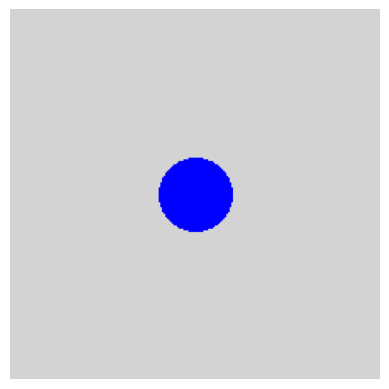

In [4]:
datagen = DataGenerator(num_samples=-1)
print(len(datagen.data))
for text, image, label, raw in datagen.data:
    print("Text:", text)
    print("Raw:", raw)
    plt.imshow(image)
    plt.axis('off')
    plt.show()
    break

In [10]:
@torch.no_grad()
def get_toy_real(batch_size=512, num_samples=-1):
    try:
        raise FileNotFoundError("Forcing to re-generate toy dataset.")
        image_features = torch.load(os.path.join("./toy_cache", "image_features.pt"), map_location='cpu').squeeze(1)
        text_features = torch.load(os.path.join("./toy_cache", "text_features.pt"), map_location='cpu').squeeze(1)
    except FileNotFoundError:
        model_name = "openai/clip-vit-base-patch32"
        model = CLIPModel.from_pretrained(model_name).to(device)
        processor = CLIPProcessor.from_pretrained(model_name)
        # model_name = "google/siglip2-base-patch32-256"
        # model = SiglipModel.from_pretrained(model_name).to(device)
        # processor = SiglipProcessor.from_pretrained(model_name)
        model = model.to(dtype=torch.float32)
        model.eval()

        data_gen = DataGenerator(num_samples=num_samples)
        
        @torch.no_grad()
        def extract_activations(model, image_tensor, text_tokens):
            image_features = model.get_image_features(pixel_values=image_tensor)
            image_features /= image_features.norm(dim=-1, keepdim=True)
            text_features = model.get_text_features(**text_tokens)
            text_features /= text_features.norm(dim=-1, keepdim=True)
            return image_features, text_features
        
        class ToyDataset(torch.utils.data.Dataset):
            def __init__(self, data, preprocess, tokenizer):
                self.data = data
                self.preprocess = preprocess
                self.tokenizer = tokenizer
                self.cache_dir = "./toy_cache"
                os.makedirs(self.cache_dir, exist_ok=True)

            def __len__(self):
                return len(self.data)
            
            def __getitem__(self, idx):
                text, image, label, _ = self.data[idx]

                image_tensor = self.preprocess(image).to(device)
                text_tokens = self.tokenizer(text).to(device)

                image_features, text_features = extract_activations(model, image_tensor, text_tokens)

                return image_features.squeeze(0), text_features.squeeze(0), label
            
        tokenizer = lambda texts: processor(text=texts, return_tensors="pt", padding=True, truncation=True)
        preprocess = lambda img: processor(images=img, return_tensors="pt")['pixel_values']
        toy_dataset = ToyDataset(data_gen.data, preprocess, tokenizer)
        raws = []
        for _, _, _, raw in tqdm(data_gen.data, desc="Extracting raw data"):
            raws.append(raw)
        torch.save(raws, os.path.join(toy_dataset.cache_dir, "raws.pt"))
        temp_loader = torch.utils.data.DataLoader(toy_dataset, batch_size=1, shuffle=True)
        image_features, text_features, labels = [], [], []
        i = 0
        for img_feats, txt_feats, label in tqdm(temp_loader, desc="Extracting features"):
            image_features.append(img_feats)
            text_features.append(txt_feats)
            labels.append(label)
            i += 1
        
        image_features = torch.stack(image_features).to('cpu').squeeze(1)
        text_features = torch.stack(text_features).to('cpu').squeeze(1)
        labels = torch.stack(labels).to('cpu').squeeze(1)
        torch.save(image_features, os.path.join(toy_dataset.cache_dir, "image_features.pt"))
        torch.save(text_features, os.path.join(toy_dataset.cache_dir, "text_features.pt"))
        torch.save(labels, os.path.join(toy_dataset.cache_dir, "labels.pt"))

    train_dataset = torch.utils.data.TensorDataset(image_features, text_features) # , labels)
    print(train_dataset.tensors[0].shape, train_dataset.tensors[1].shape) #, train_dataset.tensors[2].shape)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    
    return train_loader, image_features, text_features, labels

nb_bias = 10
def get_toy_toy(batch_size=512, num_samples=10000, target_aligned_cosim=0.4, unimodal_cosim=0.5):
    toy = ToyGeneral(d_model=512, nb_concepts=nb_bias*10, L0=10, nb_samples=num_samples, target_aligned_cosim=target_aligned_cosim, unimodal_cosim=unimodal_cosim)
    image_features = torch.tensor(toy.I, dtype=torch.float32).to(device)
    text_features = torch.tensor(toy.T, dtype=torch.float32).to(device)
    train_dataset = torch.utils.data.TensorDataset(image_features, text_features)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    return train_loader, toy

In [11]:
DATASET = "toy_toy"
batch_size = 512
if DATASET == "toy_toy":
    train_loader, gt_data = get_toy_toy(batch_size=batch_size, num_samples=10000, target_aligned_cosim=0.4, unimodal_cosim=0.99)
elif DATASET == "toy_real":
    train_loader, I, T, labels = get_toy_real(batch_size=batch_size, num_samples=-1)

# Z_gt = torch.cat([torch.tensor(gt_data.Z_I), torch.tensor(gt_data.Z_T)], dim=0).to(device)

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:02<00:00, 4338.93it/s]


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

print(I.shape, T.shape, labels.shape)
accs = 0
for l in range(labels.shape[1]):
    L = labels[:, l]
    
    # Balance positives and negatives :
    n_pos = int(L.sum().item())
    neg_idxs = torch.where(L == 0)[0]
    neg_idxs = neg_idxs[torch.randperm(len(neg_idxs))[:n_pos]]
    pos_idxs = torch.where(L == 1)[0]
    selected_idxs = torch.cat([pos_idxs, neg_idxs])
    
    L = L[selected_idxs]
    I_l = I[selected_idxs]
    T_l = T[selected_idxs]
    D_l = torch.cat([I_l, T_l], dim=1)

    # Train/test split
    idxs = torch.randperm(D_l.shape[0])
    split = int(0.8 * len(idxs))
    train_idx, test_idx = idxs[:split], idxs[split:]

    clf = LogisticRegression(max_iter=1000)
    clf.fit(D_l[train_idx], L[train_idx])
    preds = clf.predict(D_l[test_idx])

    acc = accuracy_score(L[test_idx], preds)
    print(f"Label {l} Accuracy: {acc:.4f}")
    accs += acc
print(f"Average Accuracy: {accs / labels.shape[1]:.4f}")

torch.Size([588, 512]) torch.Size([588, 512]) torch.Size([588, 21])
Label 0 Accuracy: 1.0000
Label 1 Accuracy: 0.9492
Label 2 Accuracy: 1.0000
Label 3 Accuracy: 0.9831
Label 4 Accuracy: 0.9412
Label 5 Accuracy: 0.9706
Label 6 Accuracy: 1.0000
Label 7 Accuracy: 1.0000
Label 8 Accuracy: 1.0000
Label 9 Accuracy: 1.0000
Label 10 Accuracy: 1.0000
Label 11 Accuracy: 1.0000
Label 12 Accuracy: 0.9873
Label 13 Accuracy: 1.0000
Label 14 Accuracy: 0.9118
Label 15 Accuracy: 1.0000
Label 16 Accuracy: 0.9706
Label 17 Accuracy: 1.0000
Label 18 Accuracy: 1.0000
Label 19 Accuracy: 1.0000
Label 20 Accuracy: 0.9412
Average Accuracy: 0.9836


In [13]:
d_model = 512 # image_features.shape[-1] # 512 for CLIP ViT-B/32

expansion_factor = 1
nb_concepts = nb_bias * 14 # d_model * expansion_factor

lr = 5e-4
epochs = 500

top_k = 10

UseTOPK = False

if UseTOPK:
    top_k_individual = top_k * 2
    sae = overcomplete.sae.BatchTopKSAE(d_model, nb_concepts=nb_concepts, top_k=top_k_individual*batch_size, device=device)
    alpha = 0.1  # Dead features loss penalty
    criterion_1 = lambda *args, **kwargs: overcomplete.sae.losses.top_k_auxiliary_loss(*args, **kwargs, penalty=alpha)
else:
    sae = overcomplete.sae.MpSAE(d_model, nb_concepts=nb_concepts, k=top_k, device=device)
    alpha = 0.0 # L1 penalty
    criterion_1 = lambda *args, **kwargs: overcomplete.sae.losses.mse_l1(*args, **kwargs, penalty=alpha)

sae.to(device)
sae.train()

beta = 5e-5 # Alignment penalty (0 or 5e-4)

# optimizer = torch.optim.Adam(sae.parameters(), lr=lr)

# criterion_2 = lambda *args, **kwargs: losses.alignment_penalty(*args, **kwargs, penalty=beta, alignment_metric='cosim')
# criterion = lambda *args, **kwargs: criterion_1(*args, **kwargs) + criterion_2(*args, **kwargs)

scheduler=None
steps_per_epoch = len(train_loader)
# scheduler = torch.optim.lr_scheduler.OneCycleLR(
#     optimizer, max_lr=lr, total_steps=epochs * steps_per_epoch,
# )

alpha_name = str(alpha).replace('.', '')
beta_name = str(beta).replace('.', '')

CENTER_DATASET = False
sae_name = f"{DATASET}_{"batchtopk" if UseTOPK else "MP"}_centered_{CENTER_DATASET}_{expansion_factor}_L0_{top_k}_alpha" + alpha_name + "beta" + beta_name + ".pt"
print(f"Model name: {sae_name}")

# # create the figure file to be able to do : plt.savefig(f"./figures/{sae_name.replace('.pt', '')}/modality.png", dpi=300, bbox_inches='tight')

# os.makedirs("./checkpoints/", exist_ok=True)
# os.makedirs(f"./figures/{sae_name.replace('.pt', '')}", exist_ok=True)

# try:
#     something = torch.load(f"./checkpoints/{sae_name}")
#     sae_state_dict = something['model_state_dict']
#     sae.load_state_dict(sae_state_dict)
# except FileNotFoundError:
#     logs = train.train_multimodal_sae(
#         sae, train_loader, criterion, optimizer, scheduler=scheduler, nb_epochs=epochs, device=device,
#         monitoring=1, verbose=False,
#         checkpoint_path=None, # "./checkpoints/",
#         checkpoint_interval=5, checkpoint_name=sae_name,
#     )

Model name: toy_toy_MP_centered_False_1_L0_10_alpha00beta5e-05.pt


In [14]:
print(gt_data)

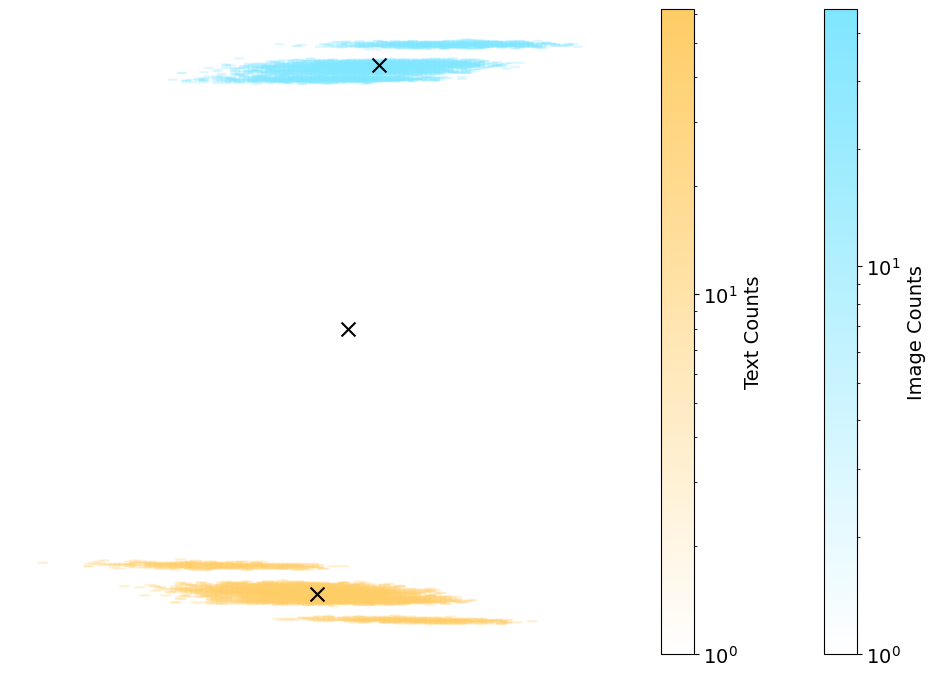

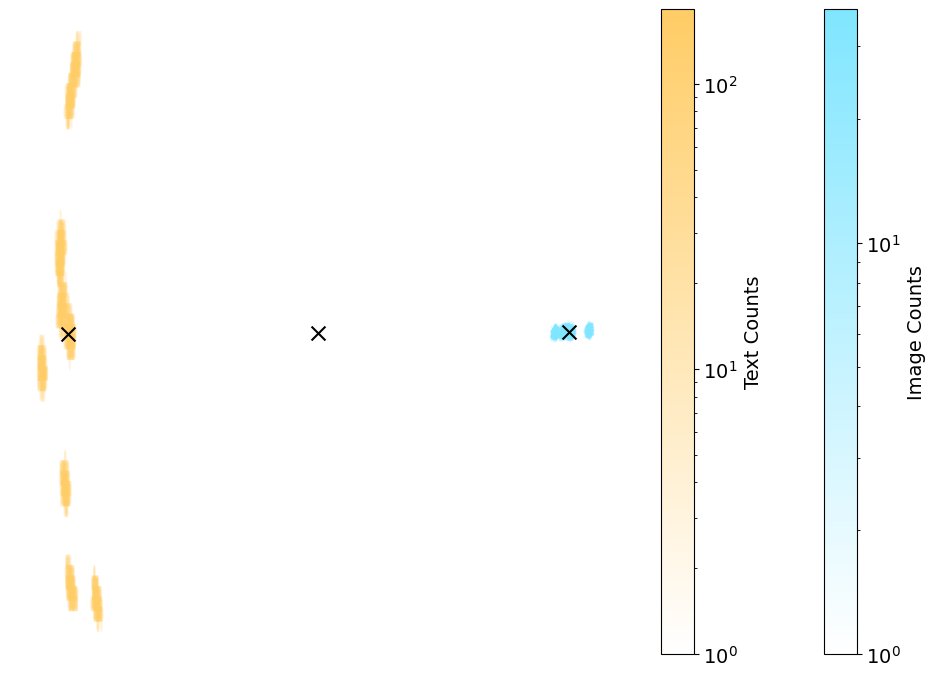

In [21]:
I = train_loader.dataset.tensors[0].cpu().detach()
T = train_loader.dataset.tensors[1].cpu().detach()
D = torch.cat([I, T], dim=0)

D_mu = D.mean(dim=0, keepdim=True)
I_mu = I.mean(dim=0, keepdim=True)
T_mu = T.mean(dim=0, keepdim=True)

d1 = D_mu.cpu().numpy()
d1 = d1 / np.linalg.norm(d1)
d2 = I_mu.cpu().numpy() - T_mu.cpu().numpy()
d2 = d2 / np.linalg.norm(d2)

plot_pca(D, d1, d2, I_mu, T_mu, D_mu, title='Projection of D on d1 = D_mu and d2 = I_mu - T_mu', save_title='data_pca_d1_d2', sae_name=sae_name)

fit_and_plot_pca(I, T, D, sae_name)

In [242]:
# Measure of energy per concept : average activation per concept
# Modality score : proportion of energy in vision vs in language

@torch.no_grad()
def measure_everything(sae, data_loader, device, return_sqr=False):
    sae.eval()
    count_per_concept = torch.zeros(sae.nb_concepts).to(device)
    E_i = torch.zeros(sae.nb_concepts).to(device)
    E_i_sqr = torch.zeros(sae.nb_concepts).to(device)
    E_t = torch.zeros(sae.nb_concepts).to(device)
    E_t_sqr = torch.zeros(sae.nb_concepts).to(device)

    n = Z_gt.shape[0]
    Z = torch.zeros((n, sae.nb_concepts)).to(device)  # shape (n, nb_concepts)
    n = n // 2

    n_images = 0
    n_texts = 0

    for image_features, text_features in tqdm(data_loader):
        n_images += image_features.shape[0]
        n_texts += text_features.shape[0]

        image_features = image_features.to(device)
        text_features = text_features.to(device)

        # Forward pass through the model
        _, z_image, _ = sae(image_features) # shape (batch_size, nb_concepts)
        _, z_text, _ = sae(text_features)

        b = z_image.shape[0]

        Z[n_images - b:n_images] = z_image
        Z[n + n_texts - b:n + n_texts] = z_text

        E_i += z_image.sum(dim=0)
        E_i_sqr += (z_image ** 2).sum(dim=0)
        E_t += z_text.sum(dim=0)
        E_t_sqr += (z_text ** 2).sum(dim=0)
        count_per_concept += (z_image != 0).sum(dim=0) + (z_text != 0).sum(dim=0)

    n_inputs = n_images + n_texts
    E = E_i + E_t
    E /= n_inputs
    E_sqr = E_i_sqr + E_t_sqr
    E_sqr /= n_inputs
    E_i /= n_images
    E_i_sqr /= n_images
    E_t /= n_texts
    E_t_sqr /= n_texts
    frequency_per_concept = count_per_concept / n_inputs
    modality_score = E_i / (E * 2)
    modality_sqr = E_i_sqr / (E_sqr * 2)

    dead_idx = (E == 0).nonzero(as_tuple=True)[0]
    E_i[dead_idx] = 1000
    E_i_sqr[dead_idx] = 1000
    E_t[dead_idx] = 1000
    E_t_sqr[dead_idx] = 1000
    modality_score[dead_idx] = -1
    modality_sqr[dead_idx] = -1

    if return_sqr:
        return E_sqr, E_i_sqr, E_t_sqr, frequency_per_concept, modality_sqr, Z
    return E, E_i, E_t, frequency_per_concept, modality_score, Z

energy_per_concept, image_energy, text_energy, frequency_per_concept, modality_score, Z = measure_everything(sae, train_loader, device, return_sqr=True)
energy_per_concept_sqr, image_energy_sqr, text_energy_sqr, frequency_per_concept, modality_score_sqr, Z = measure_everything(sae, train_loader, device, return_sqr=True)
print(f"Energy per concept: {energy_per_concept[torch.argsort(energy_per_concept, descending=True)[:10]]}")
print(f"Frequency per concept: {frequency_per_concept[torch.argsort(energy_per_concept, descending=True)[:10]]}")


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 262.05it/s]

Energy per concept: tensor([0.0678, 0.0521, 0.0401, 0.0393, 0.0370, 0.0294, 0.0292, 0.0291, 0.0288,
        0.0284], device='cuda:1')
Frequency per concept: tensor([0.2354, 0.1289, 0.0979, 0.1198, 0.0756, 0.0509, 0.0509, 0.0510, 0.0514,
        0.0497], device='cuda:1')


In [243]:
print(Z.shape, Z_gt.shape)
Z_gt = torch.cat([torch.tensor(gt_data.Z_I), torch.tensor(gt_data.Z_T)], dim=0).to(device)
a = gt_data.E
a = a / a.sum()
b = energy_per_concept_sqr
b = b.cpu().numpy() / b.sum().item()
c, gamma = metrics.Wasserstein(Z.T.float(), Z_gt.T.float(), a=b, b=a, return_plan=True, metric='cosim')
print(f"Wasserstein distance: {c:.4f}")
print(f"Gamma shape: {gamma.shape}")
mean_acc = 1 - c
print(f"Mean accuracy: {mean_acc:.4f}")

torch.Size([20000, 140]) torch.Size([20000, 100])
Wasserstein distance: 0.8195
Gamma shape: (140, 140)
Mean accuracy: 0.1805


In [244]:
print(Z.shape, Z_gt.shape)
Z_gt = torch.cat([torch.tensor(gt_data.Z_I_), torch.tensor(gt_data.Z_T_)], dim=0).to(device)
a = gt_data.E_
a = a / a.sum()
b = energy_per_concept_sqr
b = b.cpu().numpy() / b.sum().item()
c, gamma = metrics.Wasserstein(Z.T.float(), Z_gt.T.float(), a=b, b=a, return_plan=True, metric='cosim')
print(f"Wasserstein distance: {c:.4f}")
print(f"Gamma shape: {gamma.shape}")
mean_acc = 1 - c
print(f"Mean accuracy: {mean_acc:.4f}")

torch.Size([20000, 140]) torch.Size([20000, 140])
Wasserstein distance: 0.8387
Gamma shape: (140, 100)
Mean accuracy: 0.1613


In [245]:
Z_gt_norm = Z_gt.T / (Z_gt.T.norm(dim=1, keepdim=True) + 1e-8)  # Normalize Z_gt, size : (n1, n_samples)
Z_norm = Z.T / (Z.T.norm(dim=1, keepdim=True) + 1e-8)  # Normalize Z, size : (n2, n_samples)
sim = Z_gt_norm.cpu().numpy() @ Z_norm.T.cpu().numpy() # Cosine similarity, size : (n1, n2)
print(f"Cosine similarity shape: {sim.shape}")
from scipy.optimize import linear_sum_assignment
row, col = linear_sum_assignment(-sim)  # Use negative similarity for maximization, row : from 0 to n1, col : from 0 to n2
mean_acc = sim[row, col].mean()
weights = energy_per_concept_sqr[col].cpu().numpy()  # Weights for the linear assignment
weighted_mean_acc = (sim[row, col] * weights).sum() / weights.sum()
print(f"Mean accuracy after linear assignment: {mean_acc:.4f}")
print(f"Weighted mean accuracy after linear assignment: {weighted_mean_acc:.4f}")
print(f"Max cosine similarity: {sim.max():.4f}")

Cosine similarity shape: (100, 140)
Mean accuracy after linear assignment: 0.1242
Weighted mean accuracy after linear assignment: 0.2036
Max cosine similarity: 0.4276


## Geometry & contrastive objective

In [246]:
I = train_loader.dataset.tensors[0]
T = train_loader.dataset.tensors[1]
D = torch.cat([I, T], dim=0)
# I = torch.tensor(toy_04_04.I)
# T = torch.tensor(toy_04_04.T)
# D = torch.cat([torch.tensor(I, dtype=torch.float32), torch.tensor(T, dtype=torch.float32)], dim=0)

print(I.shape, T.shape, D.shape)

torch.Size([10000, 512]) torch.Size([10000, 512]) torch.Size([20000, 512])


In [247]:
I_mu = I.mean(dim=0)
T_mu = T.mean(dim=0)
D_mu = D.mean(dim=0)
print(D_mu.shape)
print(f"I_mu : {torch.norm(I_mu).item():.4f}, T_mu : {torch.norm(T_mu).item():.4f}, D_mu : {torch.norm(D_mu).item():.4f}")

torch.Size([512])
I_mu : 0.7301, T_mu : 0.7157, D_mu : 0.5598


Threshold (equal-mass): 0.40040040040040037


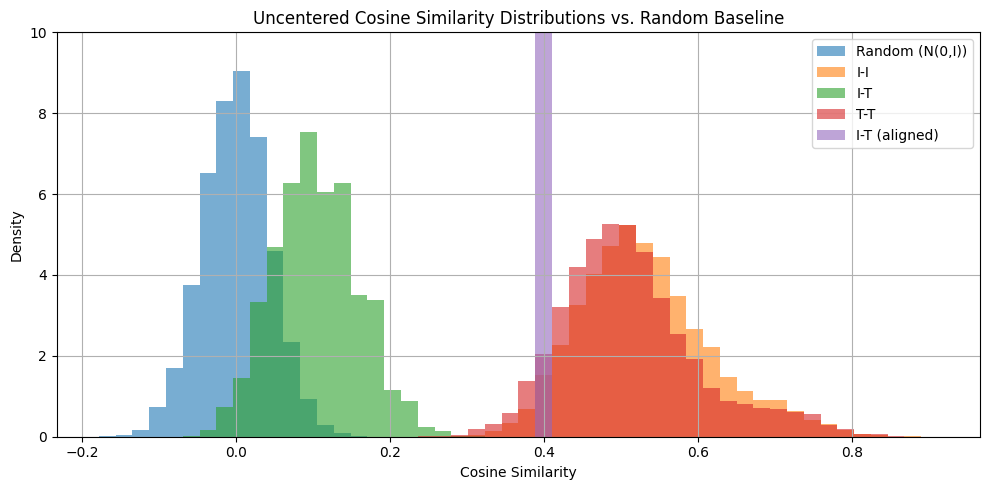

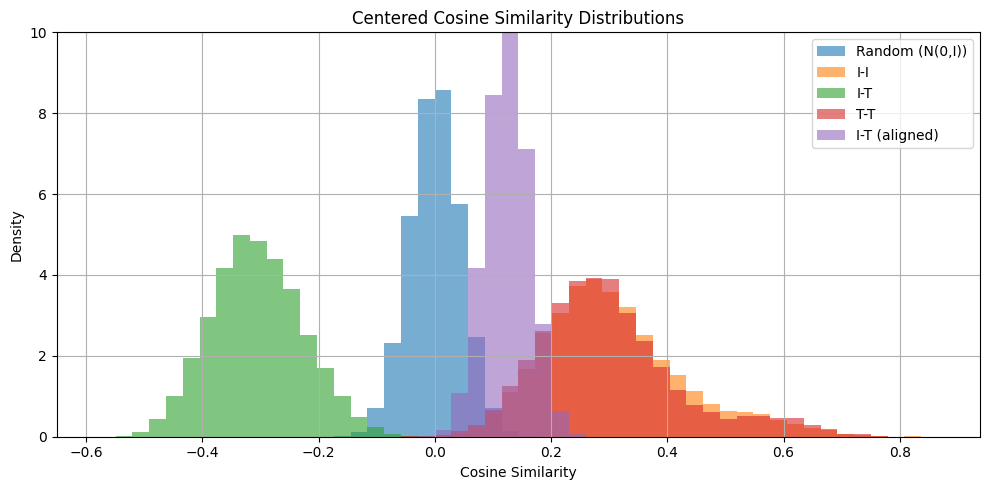

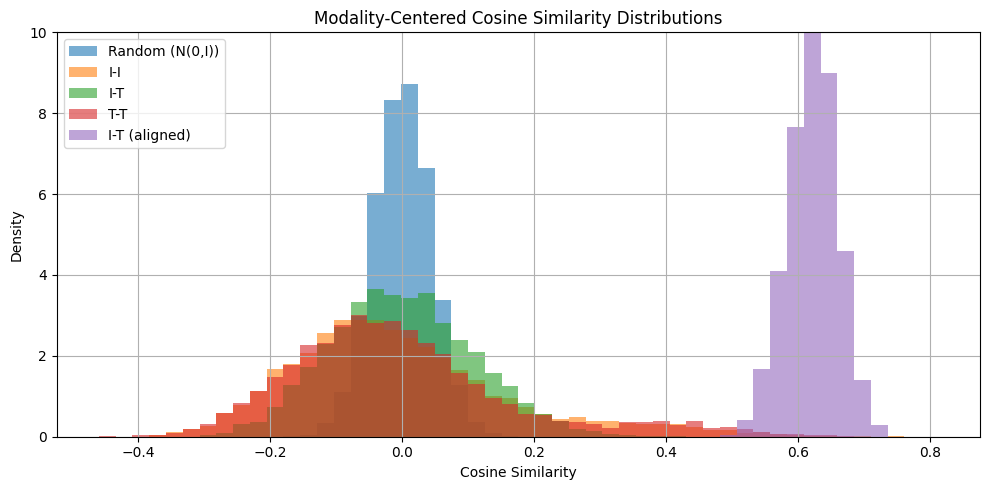

In [248]:
# I, T, D = I_bimodal, T_bimodal, D_bimodal
with torch.no_grad():
    # I - I
    J = I[torch.randperm(I.shape[0], device='cpu')]

    I_hist = torch.cosine_similarity(I, J, dim=1).cpu().numpy()
    I_D_mu_hist = torch.cosine_similarity(I - D_mu, J - D_mu, dim=1).cpu().numpy()
    I_I_mu_hist = torch.cosine_similarity(I - I_mu, J - I_mu, dim=1).cpu().numpy()


    # T - T
    J = T[torch.randperm(T.shape[0], device='cpu')]

    T_hist = torch.cosine_similarity(T, J, dim=1).cpu().numpy()
    T_D_mu_hist = torch.cosine_similarity(T - D_mu, J - D_mu, dim=1).cpu().numpy()
    T_T_mu_hist = torch.cosine_similarity(T - T_mu, J - T_mu, dim=1).cpu().numpy()

    # D - D
    J = D[torch.randperm(D.shape[0], device='cpu')]

    D_hist = torch.cosine_similarity(D, J, dim=1).cpu().numpy()
    D_D_mu_hist = torch.cosine_similarity((D - D_mu).cpu(), (J - D_mu).cpu(), dim=1).cpu().numpy()

    # I - T aligned
    J = T
    I_T_hist_aligned = torch.cosine_similarity(I, J, dim=1).cpu().numpy()
    I_T_D_mu_hist_aligned = torch.cosine_similarity(I - D_mu, J - D_mu, dim=1).cpu().numpy()
    I_T_I_mu_hist_aligned = torch.cosine_similarity(I - I_mu, J - T_mu, dim=1).cpu().numpy()

    # I - T
    J = T[torch.randperm(T.shape[0], device='cpu')]
    I_T_hist = torch.cosine_similarity(I, J, dim=1).cpu().numpy()
    I_T_D_mu_hist = torch.cosine_similarity(I - D_mu, J - D_mu, dim=1).cpu().numpy()
    I_T_I_mu_hist = torch.cosine_similarity(I - I_mu, J - T_mu, dim=1).cpu().numpy()

    # Baseline (random isotropic Gaussian)
    Rd = torch.randn_like(D)
    Rd /= Rd.norm(dim=-1, keepdim=True)
    J = Rd[torch.randperm(Rd.shape[0], device='cpu')]
    R_hist = torch.cosine_similarity(D, J, dim=1).cpu().numpy()

# plt.hist(I_hist, bins=50, density=True, alpha=0.5, label='I')
# plt.hist(I_D_mu_hist, bins=50, density=True, alpha=0.5, label='I - D_mu')
# plt.hist(I_I_mu_hist, bins=50, density=True, alpha=0.5, label='I - I_mu')
# plt.hist(T_hist, bins=50, density=True, alpha=0.5, label='T')
# plt.hist(T_D_mu_hist, bins=50, density=True, alpha=0.5, label='T - D_mu')
# plt.hist(T_T_mu_hist, bins=50, density=True, alpha=0.5, label='T - T_mu')
# plt.hist(D_hist, bins=50, density=True, alpha=0.5, label='D')
# plt.hist(D_D_mu_hist, bins=50, density=True, alpha=0.5, label='D - D_mu')
# plt.hist(I_T_hist, bins=500, density=True, alpha=0.5, label='I - T')
# plt.hist(I_T_D_mu_hist, bins=500, density=True, alpha=0.5, label='I - T - D_mu')
# plt.hist(I_T_I_mu_hist, bins=500, density=True, alpha=0.5, label='I - T - I_mu')
# plt.axvline(0, color='k', linestyle='--', linewidth=1)
# plt.xlabel('Cosine Similarity')
# plt.ylabel('Density')
# plt.title('Cosine Similarity Distribution')
# plt.legend()
# plt.show()


def plot_histograms(data_dict, title):
    plt.figure(figsize=(10, 5))
    all_data = np.concatenate(list(data_dict.values()))
    bins = np.linspace(all_data.min(), all_data.max(), 51)  # 50 bins
    for label, data in data_dict.items():
        plt.hist(data, bins=bins, alpha=0.6, label=label, density=True)
    # plt.axvline(threshold, color='red', linestyle='--', linewidth=1, label='Threshold')
    plt.title(title)
    plt.xlabel('Cosine Similarity')
    plt.ylabel('Density')
    plt.ylim([0, min(10, plt.ylim()[1])])
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def find_equal_mass_threshold(aligned, random, bins):
    # Compute histograms
    hist_a, _ = np.histogram(aligned, bins=bins, density=True)
    hist_r, _ = np.histogram(random, bins=bins, density=True)
    bin_width = np.diff(bins)[0]
    
    # Compute CDFs
    cdf_a = np.cumsum(hist_a) * bin_width
    cdf_r = np.cumsum(hist_r) * bin_width

    def objective(i):
        mass_r_above = 1 - cdf_r[i]
        mass_a_below = cdf_a[i]
        return mass_r_above - mass_a_below

    # Binary search over bins
    left, right = 0, len(bins) - 2
    while left < right:
        mid = (left + right) // 2
        if objective(mid) > 0:
            left = mid + 1
        else:
            right = mid

    threshold = (bins[left] + bins[left + 1]) / 2
    return threshold

bins = np.linspace(-1, 1, 1000)
threshold = find_equal_mass_threshold(I_T_hist_aligned, I_T_hist, bins)
print("Threshold (equal-mass):", threshold)


plot_histograms({
    "Random (N(0,I))": R_hist,
    "I-I": I_hist,
    "I-T": I_T_hist,
    "T-T": T_hist,
    "I-T (aligned)": I_T_hist_aligned,
}, "Uncentered Cosine Similarity Distributions vs. Random Baseline")

plot_histograms({
    "Random (N(0,I))": R_hist,
    "I-I": I_D_mu_hist,
    "I-T": I_T_D_mu_hist,
    "T-T": T_D_mu_hist,
    "I-T (aligned)": I_T_D_mu_hist_aligned,
}, "Centered Cosine Similarity Distributions")

plot_histograms({
    "Random (N(0,I))": R_hist,
    "I-I": I_I_mu_hist,
    "I-T": I_T_I_mu_hist,
    "T-T": T_T_mu_hist,
    "I-T (aligned)": I_T_I_mu_hist_aligned,
}, "Modality-Centered Cosine Similarity Distributions")

# Label ZOULOU_69 : threshold for
# COCO : 0.238
# CC3M : /
# LAION 400M : None - already thresholded at 0.3. 


## Modality score

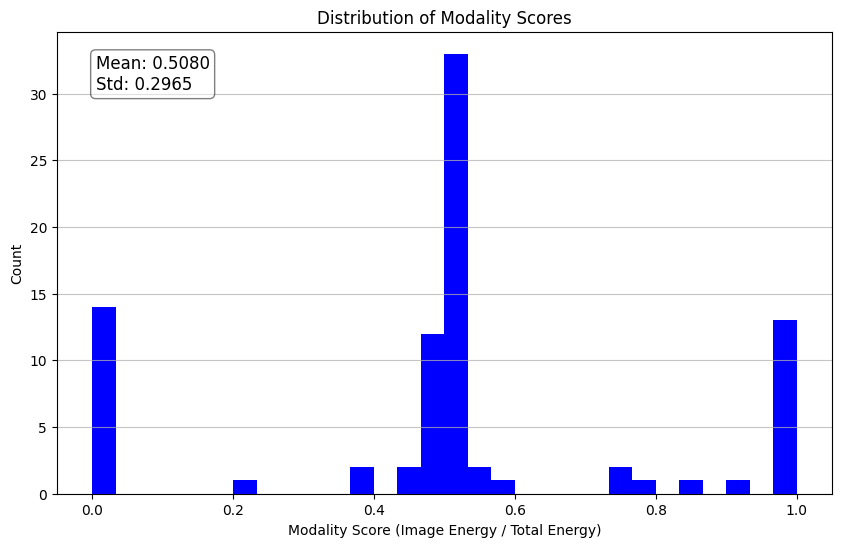

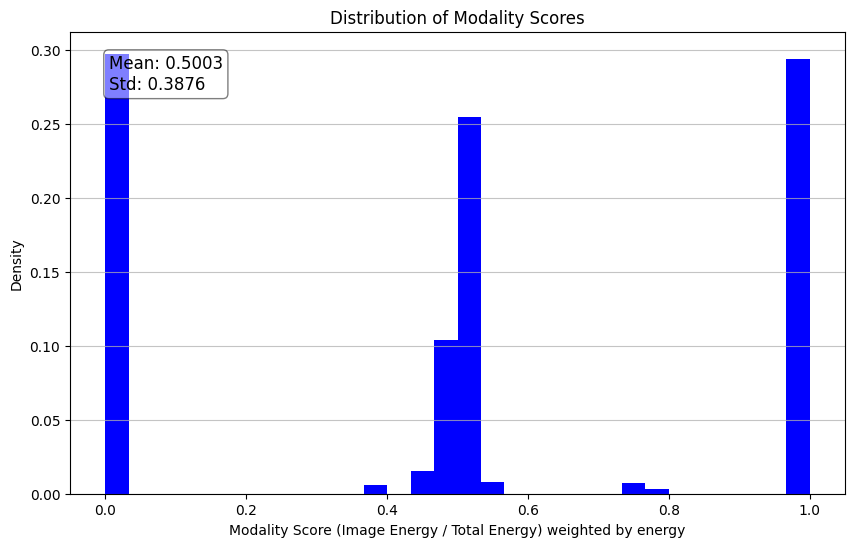

/tmp/ipykernel_3876512/1226830537.py:61: UserWarning: Only one of 'bins' and 'norm' arguments can be supplied, ignoring bins='log'
  plt.hexbin(x, y, C=((x + y) / (x + y).sum() if weighted else None), reduce_C_function=(np.sum if weighted else None), gridsize=100, bins='log', cmap='magma_r', xscale='log', yscale='log', norm=(LogNorm(vmin=max(1e-4, ((x + y) / (x + y).sum()).min())) if weighted else None))


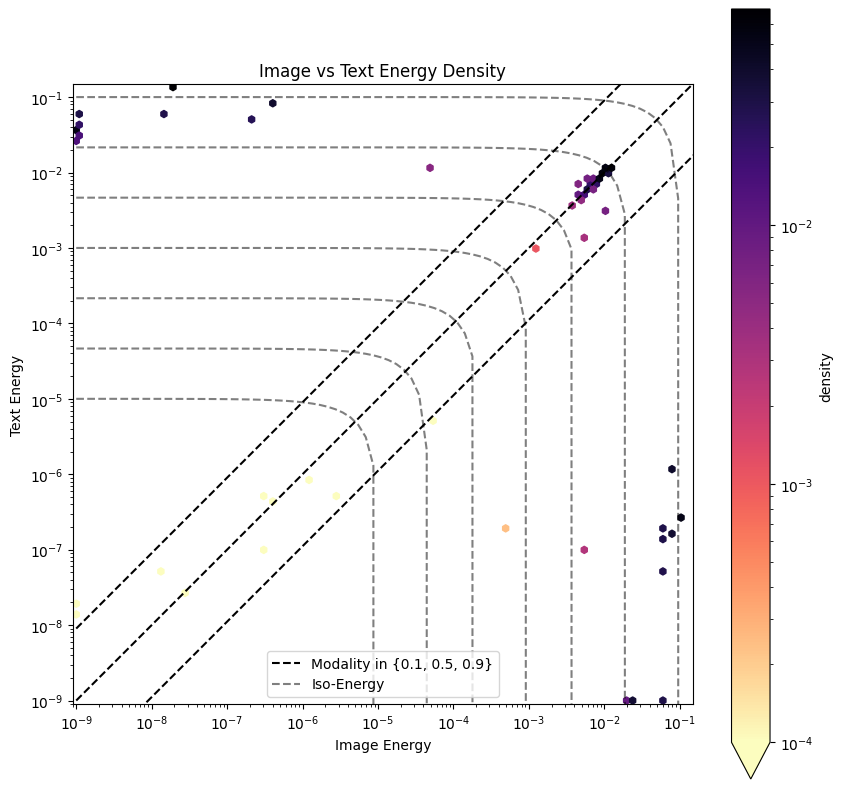

In [249]:
# plot modality score

def plot_modality_score(modality_score, energy, frequency):
    modality_temp = modality_score[modality_score != -1].cpu()
    energy = energy[modality_score != -1].cpu()
    frequency = frequency[modality_score != -1].cpu()

    modality_temp = modality_temp[frequency < 0.9]
    energy = energy[frequency < 0.9]

    mu = modality_temp.mean()
    std = modality_temp.std()
    plt.figure(figsize=(10, 6))
    plt.hist(modality_temp.cpu().numpy(), bins=30, range=(0, 1), color='blue')
    plt.title("Distribution of Modality Scores")
    plt.xlabel("Modality Score (Image Energy / Total Energy)")
    plt.ylabel("Count")
    # plt.yscale("log")
    plt.grid(axis='y', alpha=0.75)
    plt.text(0.05, 0.95, f"Mean: {mu:.4f}\nStd: {std:.4f}", transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', bbox=dict(boxstyle="round", facecolor="white", alpha=0.5))
    plt.savefig(f"./figures/{sae_name.replace('.pt', '')}/modality.png", dpi=300, bbox_inches='tight')
    plt.savefig(f"./figures/{sae_name.replace('.pt', '')}/modality.pdf")
    plt.show()
    
    mu_weighted = (modality_temp * energy).sum() / energy.sum()
    std_weighted = torch.sqrt(((modality_temp - mu_weighted) ** 2 * energy).sum() / energy.sum())
    plt.figure(figsize=(10, 6))
    plt.hist(modality_temp.cpu().numpy(), bins=30, range=(0, 1), color='blue', weights=energy.cpu().numpy())
    plt.title("Distribution of Modality Scores")
    plt.xlabel("Modality Score (Image Energy / Total Energy) weighted by energy")
    plt.ylabel("Density")
    # plt.yscale("log")
    plt.grid(axis='y', alpha=0.75)
    plt.text(0.05, 0.95, f"Mean: {mu_weighted:.4f}\nStd: {std_weighted:.4f}", transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', bbox=dict(boxstyle="round", facecolor="white", alpha=0.5))
    plt.savefig(f"./figures/{sae_name.replace('.pt', '')}/modality_weighted.png", dpi=300, bbox_inches='tight')
    plt.savefig(f"./figures/{sae_name.replace('.pt', '')}/modality_weighted.pdf")
    plt.show()

plot_modality_score(modality_score, energy_per_concept, frequency_per_concept)

# scatter points based on image vs text energy
def plot_energy_density(image_energy, text_energy, weighted=False):
    # TODO : add x and y marginal histograms
    sorted_indices = torch.argsort(image_energy + text_energy, descending=True)
    x = image_energy[sorted_indices].cpu().numpy() + 1e-9
    y = text_energy[sorted_indices].cpu().numpy() + 1e-9

    live_idx = torch.tensor(x + y != 2000).nonzero(as_tuple=True)[0]
    x = x[live_idx]
    y = y[live_idx]

    plt.figure(figsize=(10, 10))
    x_line = torch.logspace(-9, 1, steps=100).cpu()
    plt.plot(x_line, x_line, '--', color='black', label='Modality in {0.1, 0.5, 0.9}')
    plt.plot(x_line, 9 * x_line, '--', color='black')
    plt.plot(x_line, x_line / 9, '--', color='black')
    steps = torch.logspace(-5, 1, steps=10).cpu()
    for i in steps:
        plt.plot(x_line, i - x_line, 'k--', alpha=0.5, label='Iso-Energy' if i == steps[0] else None)

    plt.hexbin(x, y, C=((x + y) / (x + y).sum() if weighted else None), reduce_C_function=(np.sum if weighted else None), gridsize=100, bins='log', cmap='magma_r', xscale='log', yscale='log', norm=(LogNorm(vmin=max(1e-4, ((x + y) / (x + y).sum()).min())) if weighted else None))
    plt.colorbar(label=('density' if weighted else "count"), extend=('min' if weighted else None))
    plt.xlabel('Image Energy')
    plt.ylabel('Text Energy')
    plt.title(f"Image vs Text Energy Density")
    plt.legend()
    #plt.grid()

    # Enforce square log-log plot
    all_vals = np.concatenate([x, y])
    min_val, max_val = all_vals.min(), all_vals.max()
    plt.xlim(min_val * 0.9, max_val * 1.1)
    plt.ylim(min_val * 0.9, max_val * 1.1)
    plt.gca().set_aspect('equal', adjustable='box')

    plt.savefig(f"./figures/{sae_name.replace('.pt', '')}/energy_scatter{("_weighted" if weighted else "")}.png", dpi=300, bbox_inches='tight')
    plt.savefig(f"./figures/{sae_name.replace('.pt', '')}/energy_scatter{("_weighted" if weighted else "")}.pdf")

    plt.show()

# plot_energy_density(image_energy, text_energy)
plot_energy_density(image_energy, text_energy, weighted=True)

In [250]:
import ot

# find the emd between SAE.dictionary.fused_dictionary and the target distribution :
X = sae.dictionary._fused_dictionary.cpu().numpy()
a = energy_per_concept.cpu().numpy()
a = a / a.sum()  # Normalize to get a probability distribution
# Y = np.vstack([gt_data.D_I, gt_data.D_T, gt_data.D_B_I_, gt_data.D_B_T_])
# b = gt_data.E_
Y = np.vstack([gt_data.D_I, gt_data.D_T, gt_data.D_B, gt_data.D_B_I, gt_data.D_B_T])
b = gt_data.E[:]
b = b / b.sum()  # Normalize to get a probability distribution
print("X shape:", X.shape, "Y shape:", Y.shape, "a shape:", a.shape, "b shape:", b.shape)

c = metrics.Wasserstein(
    torch.tensor(X).float(), torch.tensor(Y).float(), a=a, b=b, metric='cosim',
)
print("Wasserstein distance (cosim):", c)

X shape: (140, 512) Y shape: (140, 512) a shape: (140,) b shape: (140,)
Wasserstein distance (cosim): 0.33576304


In [251]:
import ot

# find the emd between SAE.dictionary.fused_dictionary and the target distribution :
X = sae.dictionary._fused_dictionary.cpu().numpy()
a = energy_per_concept.cpu().numpy()
a = a / a.sum()  # Normalize to get a probability distribution
Y = np.vstack([gt_data.D_I, gt_data.D_T, gt_data.D_B_I_, gt_data.D_B_T_])
b = gt_data.E_
# Y = np.vstack([gt_data.D_I, gt_data.D_T, gt_data.D_B])
# b = gt_data.E[:60]
b = b / b.sum()  # Normalize to get a probability distribution
print("X shape:", X.shape, "Y shape:", Y.shape, "a shape:", a.shape, "b shape:", b.shape)

c = metrics.Wasserstein(
    torch.tensor(X).float(), torch.tensor(Y).float(), a=a, b=b, metric='cosim',
)
print("Wasserstein distance (cosim):", c)

X shape: (140, 512) Y shape: (100, 512) a shape: (140,) b shape: (100,)
Wasserstein distance (cosim): 0.18455768


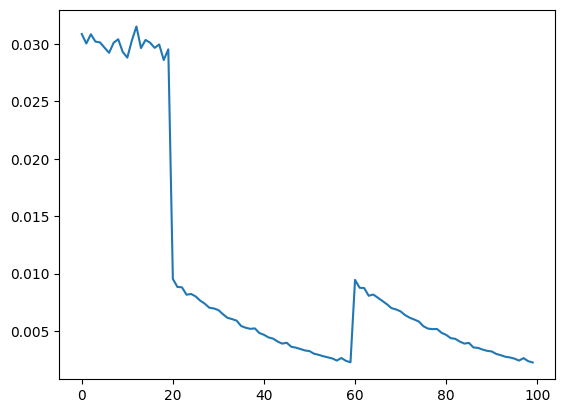

In [252]:
plt.plot(gt_data.E_, label='Target Energy')